In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
si = np.array([[100,1],[1,100]])
phi = np.array([[2,1],[1,2]])

In [3]:
def dectobin(val):
    x0 = val%2
    x1 = val//2
    return [x1,x0]

def bintodec(x):
     return int(''.join(str(el) for  el in x.reshape(-1)),2)
    
def gibbs_update(x,j,p_j):
    x_curr = x.copy()
    if j==0:
        x_new = np.random.choice([0,1],p=p_j[:,x_curr[1],x_curr[2],x_curr[3]])
    if j==1:
        x_new = np.random.choice([0,1],p=p_j[x_curr[0],:,x_curr[2],x_curr[3]])
    if j==2:
        x_new = np.random.choice([0,1],p=p_j[x_curr[0],x_curr[1],:,x_curr[3]])
    if j==3:
        x_new = np.random.choice([0,1],p=p_j[x_curr[0],x_curr[1],x_curr[2],:])
    x_curr[j] = x_new
    return x_curr

In [4]:
def gibbs_sampler(no_iter=1000,n_samples=1000,tol=1e-2):

    x = np.zeros(4,'int')
    # calculating the single variable marginals
    # utilising the independencies satisified the distribution given
    
    '''
    x1/x(-1) ~ x1/(x1,x2)
    '''
        
    p_1 = np.zeros([2,2,2,2])
    p_12 = si/np.sum(si,axis=0)
    for x3 in range(2):
        for x4 in range(2):
            p_1[:,:,x3,x4] = p_12
    
    '''
    x2/x(-2) ~ x2/(x1,x3)
    '''
        
    p_2 = np.zeros([2,2,2,2])
    for x1 in range(2):
        for x3 in range(2):
            for x4 in range(2):
                temp = si[x1,:]*phi[:,x3]
                p_2[x1,:,x3,x4] = temp/np.sum(temp)
        
        
    '''
    x3/x(-3) ~ x3/(x2,x4)
    '''
    p_3 = np.zeros([2,2,2,2])
    for x1 in range(2):
        for x2 in range(2):
            for x4 in range(2):
                temp = si[:,x4]*phi[x2,:]
                p_3[x1,x2,:,x4] = temp/np.sum(temp)
    
    
    '''
    x4/x(-4) ~ x4/(x3)
    '''
    p_4 = np.zeros([2,2,2,2])
    p_43 = si.T/np.sum(si.T,axis=0)
    for x1 in range(2):
        for x2 in range(2):
            p_4[x1,x2,:,:] = p_43.T

    p_tot=[p_1,p_2,p_3,p_4]

    x_burnin = []
    mean_ = bintodec(x)
    mean = 1
    
    i=0
    while((abs(mean_-mean)/(mean_+1)) > tol and i<no_iter):
        if(i>1):
            mean_ = np.mean(x_burnin[:-1])
        
        # loop over all x1,x2,x3,x4
        for j in range(4):
            x = gibbs_update(x,j,p_tot[j])
            x_burnin.append(bintodec(x))
            mean = np.mean(x_burnin)
        i+=1
        print(mean,mean_)
    burn_in = i
    
    print("Burn-in Steps of normal gibbs:{}".format(burn_in))
    
    samples = np.zeros([n_samples*4])
    for i in range(n_samples):
        # loop over all x1,x2,x3,x4
        for j in range(4):
            x = gibbs_update(x,j,p_tot[j])
            samples[4*i+j] = bintodec(x)
    
    return samples

In [5]:
def blocks_gibbs_update(x,j,p_j):
    x_curr = x.copy()
    if j==0:
        x_new = np.random.choice([0,1,2,3],p=(p_j[:,:,x_curr[2],x_curr[3]].reshape(-1)))
    if j==1:    
        x_new = np.random.choice([0,1,2,3],p=(p_j[x_curr[0],x_curr[1],:,:].reshape(-1)))
    x_curr[2*j:2*(j+1)] = dectobin(x_new)
    return x_curr

In [6]:
def double_marginal(x12):
    d_marg = np.zeros([2,2,2,2])
    
    for x1 in range(2):
        for x2 in range(2):
            for x3 in range(2):
                for x4 in range(2):
                    if(x12=='12'):
                        d_marg[x1,x2,x3,x4] = si[x1,x2]*phi[x2,x3]
                    else:
                        d_marg[x1,x2,x3,x4] = si[x3,x4]*phi[x2,x3]
                    
    return d_marg

In [7]:
def block_gibbs_sampler(no_iter=1000,n_samples=1000,tol=1e-2):
    
    x = np.zeros(4,'int')
    
    '''
    x1x2/-(x1x2)
    '''
        
    p_12 = double_marginal('12')
    #normalising
    p_12 = p_12/np.sum(np.sum(p_12,axis=0),axis=0)
    
    '''
    x3x4/-(x3x4)
    '''
    p_34 = double_marginal('34')
    #normalising
    p_34 = p_34/np.sum(np.sum(p_34,axis=-1),axis=-1)
    
    p_tot = [p_12,p_34]
    x_burnin = []
    
#     mean_ = bintodec(x)
    mean = 0
    
    i=0
    diff = 1
    while(abs(diff) > tol and i<no_iter):
        # loop over all variables
#         if(i>1):
#             mean_ = np.mean(x_burnin[:-1])
        
        for j in range(2):
            x = blocks_gibbs_update(x,j,p_tot[j])
            x_burnin.append(bintodec(x))
            diff = (bintodec(x)-mean)/(i+1)
            
        mean = mean + diff
        i+=1
#         print(diff,bintodec(x))
    burn_in = i
    
    print("Burn-in Steps:{}".format(burn_in))
    
    samples = np.zeros([n_samples*2])
    for i in range(n_samples):
        # loop over all variables
        for j in range(2):
            x = blocks_gibbs_update(x,j,p_tot[j])        
            samples[2*i+j] = bintodec(x)
            
    return samples

In [8]:
samples = gibbs_sampler(tol=1e-2)

11.0 0
11.5 0
11.6666666667 11.4285714286
11.75 11.6363636364
Burn-in Steps of normal gibbs:4


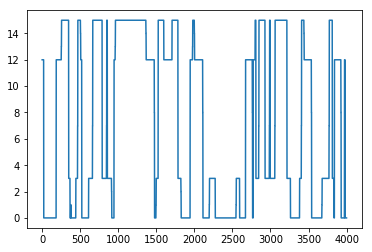

In [9]:
plt.plot(samples)
plt.show()

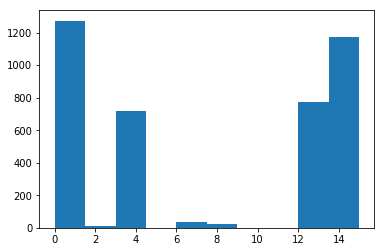

In [10]:
plt.hist(samples)
plt.show()

In [11]:
samples = block_gibbs_sampler(tol=1e-2)

Burn-in Steps:2


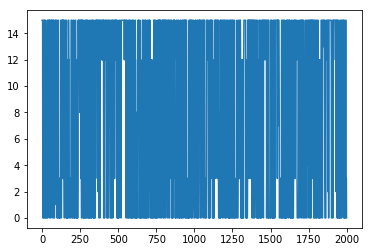

In [12]:
plt.plot(samples)
plt.show()

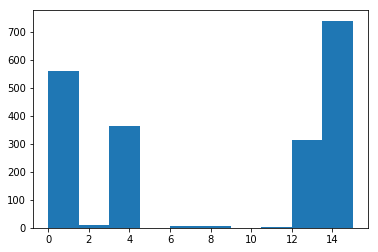

In [13]:
plt.hist(samples)
plt.show()